<img src="https://upload.wikimedia.org/wikipedia/fr/8/81/Sciences_SU.png" width="240" height="240" align="center"/>


# MLA 703. RNN-LSTM et architectures avancées [Analyse de sentiment]

In [1]:
# Dans ce notebook, nous allons nous intéresser à des tâches d'analyse de sentiments
# -> c'est à dire prédire un label de sentiment (ici positif ou négatif) à partir d'un texte

# Ce notebook vise à approfondir : 
# - L'application du DL sur des données textuelles
# - La compréhension des architectures RNN avancées comme les LSTM et les mécanismes d'attention
#

# 1. Importation des modules

In [2]:
# On importe les librairies usuelless
import math
import numpy as np
import matplotlib.pyplot as plt

# On désactive les warnings
import warnings
warnings.filterwarnings('ignore')


## 1. Charger les données

## 2. Formater/Préparer les données

In [3]:
# On charge directement la base IMDB par les datasets de Keras
# La méthode load_date possède pas mal d'options et de propriétés intéressantes (voir description) :
# 1) Sépare les jeux d'entrainement et de test
# 2) num_words : Top most frequent words to consider.
# 3) skip_top : Top most frequent words to ignore (they will appear as oov_char value in the sequence data).
# 4) maxlen : Maximum sequence length. Any longer sequence will be truncated.
# 5) seed : Seed for reproducible data shuffling.
# 6) start_char : The start of a sequence will be marked with this character. Set to 1 because 0 is usually the padding character.
# 7) oov_char : words that were cut out because of the num_words or skip_top limit will be replaced with this character.
# 8) index_from : Index actual words with this index and higher.

from tensorflow.keras.datasets import imdb

num_words = 5000
max_len   =  100

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words, maxlen=max_len)
                                            

In [4]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# On padde les séquences

print("La phrase avant padding est : \n {}". format(x_train[0]))

# On padde les séquence de mot
max_len       = 100
x_train       = pad_sequences(x_train, maxlen=max_len, truncating='post')
x_test        = pad_sequences(x_test, maxlen=max_len, truncating='post')

print("La phrase paddée sur une longueur {} est : \n {}". format(max_len, x_train[0]))
      
print("x_train lenght:", len(x_train))    

La phrase avant padding est : 
 [1, 778, 128, 74, 12, 630, 163, 15, 4, 1766, 2, 1051, 2, 32, 85, 156, 45, 40, 148, 139, 121, 664, 665, 10, 10, 1361, 173, 4, 749, 2, 16, 3804, 8, 4, 226, 65, 12, 43, 127, 24, 2, 10, 10]
La phrase paddée sur une longueur 100 est : 
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    1  778  128   74   12  630  163   15    4 1766    2 1051    2
   32   85  156   45   40  148  139  121  664  665   10   10 1361  173
    4  749    2   16 3804    8    4  226   65   12   43  127   24    2
   10   10]
x_train lenght: 2773


## 3. Déclaration du réseau

La tâche consiste à prédire la valence d'un texte à partir de son contenu.
Pour ce faire nous allons créer une architecture many-to-one 
avec les réseaux RNNs
Le problème consiste à implémenter et apprendre
des réseaux avec - par exemple - les configurations suivantes : 
On va comparer les configurations suivantes : 
- Simple RNN avec dropout (avec un taux de 25% en sortie du RNN)
- RNN-LSTM gauche-droite classique
- LSTM bi-directionnel et return_sequences = False
- Plusieurs couches au choix. On veillera en particulier 
  à la valeur des arguments return_sequences
  
Dans le rapport à faire directement dans le notebook, on prendra soin de :
- reporter les losses sur les ensembles d'entrainement et de validation
- mesurer l'accuracy sur l'ensemble de test
On commentera les résultats obtenus en comparant les configurations
Quelle est la configuration donnant la meilleure performance ? 
Pourquoi ?

Aide : une couche LSTM bi-directionnelle est obtenue en appliquant sur la même couche une couche LSTM et une couche Bidirectional

In [5]:
# On importe les librairies pour le RNN
from tensorflow.keras.layers import Dense , Input , SimpleRNN, LSTM , Embedding, Dropout
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D 
from tensorflow.keras.regularizers import l2
#from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

embed_size = 128                                                   # dimension de l'embedding
RNN_size   = 64

# Example d'architecture pour le réseau RNN simple avec dropout
model = Sequential()
model.add(Embedding(num_words, embed_size))                 # layer embedding
model.add(SimpleRNN(RNN_size, return_sequences = False))    # layer RNN
model.add(Dropout(0.25))                                    # layer Dropout
model.add(Dense(1))                                         # layer Dense

# On affiche l'architecture de notre modèle
model.summary()

# On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         640000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                12352     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 652,417
Trainable params: 652,417
Non-trainable params: 0
_________________________________________________________________


## 4. Entrainement du réseau

In [6]:
# On entraine le réseau
batch_size = 64                                                             # tailles des mini-batch
epochs = 10                                                                 # nombre d'époques
history = model.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2) # on entraine

Epoch 1/10
35/35 [==============================] - 2s 24ms/step - loss: 1.7431 - accuracy: 0.5023 - val_loss: 0.7171 - val_accuracy: 0.5694
Epoch 2/10
35/35 [==============================] - 1s 19ms/step - loss: 0.7598 - accuracy: 0.7096 - val_loss: 0.8770 - val_accuracy: 0.5550
Epoch 3/10
35/35 [==============================] - 1s 18ms/step - loss: 0.2977 - accuracy: 0.9040 - val_loss: 1.3419 - val_accuracy: 0.5640
Epoch 4/10
35/35 [==============================] - 1s 18ms/step - loss: 0.1083 - accuracy: 0.9815 - val_loss: 1.6487 - val_accuracy: 0.5550
Epoch 5/10
35/35 [==============================] - 1s 18ms/step - loss: 0.0610 - accuracy: 0.9955 - val_loss: 2.0374 - val_accuracy: 0.5622
Epoch 6/10
35/35 [==============================] - 1s 19ms/step - loss: 0.0509 - accuracy: 0.9973 - val_loss: 2.1339 - val_accuracy: 0.5712
Epoch 7/10
35/35 [==============================] - 1s 17ms/step - loss: 0.0429 - accuracy: 0.9973 - val_loss: 2.5136 - val_accuracy: 0.5550
Epoch 8/10
35

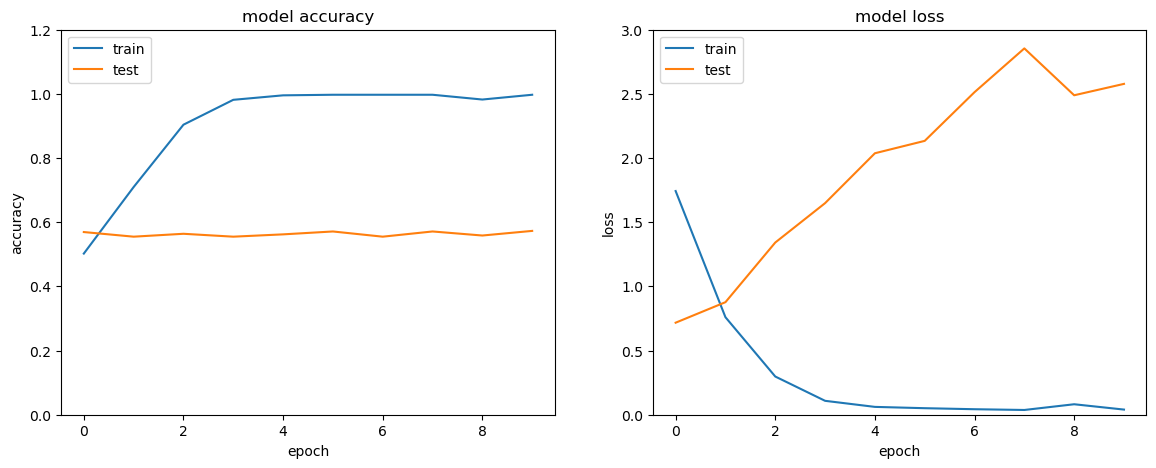

In [7]:
def plot_history(history, mod_name):
    plt.figure(figsize=[14,5])


    # On trace la loss et l'accuracy du modèle
    # On trace l'évolution de l'accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy']) 
    plt.title(mod_name + ' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.ylim([0,1.2])
    plt.legend(['train', 'test'], loc='upper left')

    # On trace l'évolution de la loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(mod_name + ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.ylim([0,3])
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_history(history, "model")

In [8]:
def pred(modelx, x_test) :
    # On prédit sur les données de test
    y_hat = modelx.predict(x_test)

    # On tranforme les prédictions en labels
    i_pos = [i for i in range(len(y_hat)) if y_hat[i]>0]
    i_neg = [i for i in range(len(y_hat)) if y_hat[i]<=0]

    y_pred   = np.zeros(len(y_hat))
    y_pred[i_pos] = 1
    y_pred[i_neg] = 0

    return y_pred

y_pred = pred(model, x_test)

93/93 [==============================] - 0s 4ms/step


In [9]:
# On importe les librairies pour l'évaluation
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix

# On calcule la matrice de confusion
cm_test = confusion_matrix(y_test, y_pred)
print('La matrice de confusion sur le jeu de test :\n', cm_test, '\n')

# On calcul le score d accuracy
acc_train=accuracy_score(y_test, y_pred)
print("L'accuracy sur le jeu de test est :\n", acc_train)


La matrice de confusion sur le jeu de test :
 [[ 295 1064]
 [ 216 1388]] 

L'accuracy sur le jeu de test est :
 0.5680053999325009


# RNN-LSTM gauche-droite classique


In [10]:
# on definie model2 : RNN-LSTM gauche-droite classique 

model2 = Sequential()

model2.add(Embedding(num_words, embed_size))    
model2.add(LSTM(units=64))
model2.add(Dense(1, activation='sigmoid'))

# On affiche l'architecture de notre modèle
model2.summary()

# On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         640000    
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 689,473
Trainable params: 689,473
Non-trainable params: 0
_________________________________________________________________


In [11]:
history2 = model2.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2) # on entraine

Epoch 1/10


35/35 [==============================] - 3s 54ms/step - loss: 0.6609 - accuracy: 0.5784 - val_loss: 0.5466 - val_accuracy: 0.7892
Epoch 2/10
35/35 [==============================] - 2s 49ms/step - loss: 0.3922 - accuracy: 0.8688 - val_loss: 0.4014 - val_accuracy: 0.8216
Epoch 3/10
35/35 [==============================] - 2s 49ms/step - loss: 0.1767 - accuracy: 0.9378 - val_loss: 0.3349 - val_accuracy: 0.8523
Epoch 4/10
35/35 [==============================] - 2s 49ms/step - loss: 0.0853 - accuracy: 0.9770 - val_loss: 0.5027 - val_accuracy: 0.7946
Epoch 5/10
35/35 [==============================] - 2s 49ms/step - loss: 0.0510 - accuracy: 0.9847 - val_loss: 0.5440 - val_accuracy: 0.8126
Epoch 6/10
35/35 [==============================] - 2s 48ms/step - loss: 0.1085 - accuracy: 0.9639 - val_loss: 0.4194 - val_accuracy: 0.8198
Epoch 7/10
35/35 [==============================] - 2s 48ms/step - loss: 0.0372 - accuracy: 0.9914 - val_loss: 0.4708 - val_accuracy: 0.8216
Epoch 8/10
35/35 [======

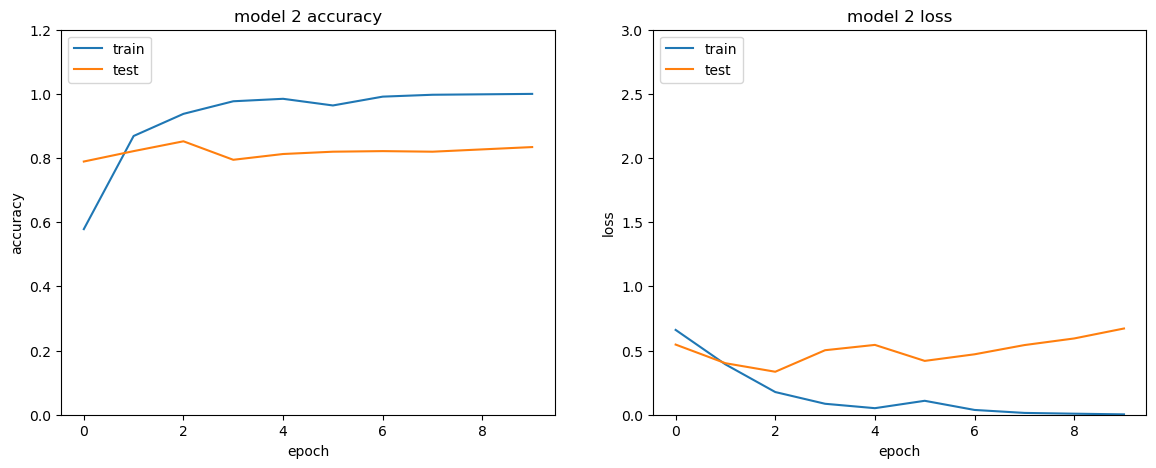

In [12]:
plot_history(history2, "model 2")

In [13]:
y_pred = pred(model2, x_test)

# On calcule la matrice de confusion
cm_test_2 = confusion_matrix(y_test, y_pred)
print('La matrice de confusion sur le jeu de test :\n', cm_test_2, '\n')

# On calcul le score d accuracy
acc_train_2 = accuracy_score(y_test, y_pred)
print("L'accuracy sur le jeu de test est :\n", acc_train_2)

93/93 [==============================] - 1s 10ms/step
La matrice de confusion sur le jeu de test :
 [[   0 1359]
 [   0 1604]] 

L'accuracy sur le jeu de test est :
 0.5413432332095849


# LSTM bi-directionnel avec return_sequences = False


In [29]:
# Modèle 3 : LSTM bi-directionnel et return_sequences=False
model3 = Sequential()
model3.add(Embedding(num_words, embed_size))    
model3.add(Bidirectional(LSTM(units=64, return_sequences=False)))
model3.add(Dense(1, activation='sigmoid'))

# On affiche l'architecture de notre modèle
model3.summary()

# On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 128)         640000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 738,945
Trainable params: 738,945
Non-trainable params: 0
_________________________________________________________________


In [30]:
history3 = model3.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2) # on entraine

Epoch 1/10
35/35 [==============================] - 5s 87ms/step - loss: 0.6807 - accuracy: 0.5433 - val_loss: 0.6097 - val_accuracy: 0.6036
Epoch 2/10
35/35 [==============================] - 3s 74ms/step - loss: 0.4837 - accuracy: 0.8233 - val_loss: 0.4281 - val_accuracy: 0.8036
Epoch 3/10
35/35 [==============================] - 3s 76ms/step - loss: 0.2319 - accuracy: 0.9184 - val_loss: 0.3810 - val_accuracy: 0.8162
Epoch 4/10
35/35 [==============================] - 3s 77ms/step - loss: 0.1200 - accuracy: 0.9635 - val_loss: 0.3527 - val_accuracy: 0.8450
Epoch 5/10
35/35 [==============================] - 3s 77ms/step - loss: 0.0681 - accuracy: 0.9829 - val_loss: 0.3974 - val_accuracy: 0.8432
Epoch 6/10
35/35 [==============================] - 3s 77ms/step - loss: 0.0405 - accuracy: 0.9919 - val_loss: 0.4287 - val_accuracy: 0.8450
Epoch 7/10
35/35 [==============================] - 3s 90ms/step - loss: 0.0164 - accuracy: 0.9977 - val_loss: 0.5267 - val_accuracy: 0.8360
Epoch 8/10
35

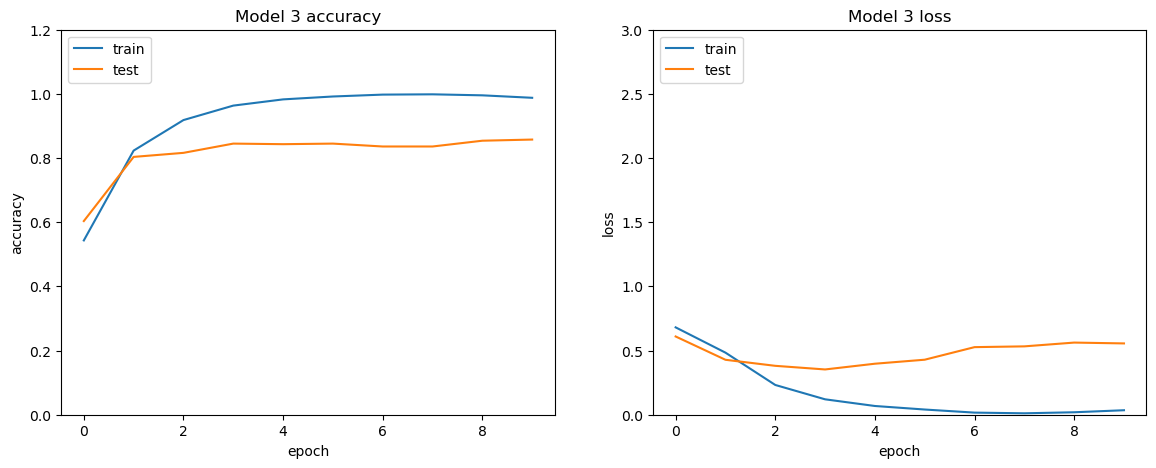

In [31]:
plot_history(history3, "Model 3")

In [43]:
y_pred = pred(model3, x_test)

# On calcule la matrice de confusion
cm_test_3 = confusion_matrix(y_test, y_pred)
print('La matrice de confusion sur le jeu de test :\n', cm_test_3, '\n')

# On calcul le score d accuracy
acc_train_3 = accuracy_score(y_test, y_pred)
print("L'accuracy sur le jeu de test est :\n", acc_train_3)

93/93 [==============================] - 1s 11ms/step
La matrice de confusion sur le jeu de test :
 [[   0 1359]
 [   0 1604]] 

L'accuracy sur le jeu de test est :
 0.5413432332095849


# LSTM bi-directionnel et LSTM classic

In [20]:
# Modèle 4 : LSTM bi-directionnel et return_sequences=False
model4 = Sequential()
model4.add(Embedding(num_words, embed_size)) 

model4.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model4.add(Dropout(0.2))

model4.add(LSTM(units=64))
model4.add(Dropout(0.2))

model4.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))

# On affiche l'architecture de notre modèle
model4.summary()

# On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 128)         640000    
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 256)        263168    
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, None, 256)         0         
                                                                 
 lstm_6 (LSTM)               (None, 64)                82176     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                      

In [21]:
history4 = model4.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2) # on entraine

Epoch 1/10
35/35 [==============================] - 15s 354ms/step - loss: 0.6530 - accuracy: 0.6195 - val_loss: 0.6164 - val_accuracy: 0.7189
Epoch 2/10
35/35 [==============================] - 12s 339ms/step - loss: 0.3789 - accuracy: 0.8593 - val_loss: 0.4810 - val_accuracy: 0.8036
Epoch 3/10
35/35 [==============================] - 15s 429ms/step - loss: 0.1968 - accuracy: 0.9387 - val_loss: 0.5790 - val_accuracy: 0.7730
Epoch 4/10
35/35 [==============================] - 16s 464ms/step - loss: 0.1185 - accuracy: 0.9693 - val_loss: 0.6181 - val_accuracy: 0.7802
Epoch 5/10
35/35 [==============================] - 17s 482ms/step - loss: 0.0784 - accuracy: 0.9820 - val_loss: 0.5558 - val_accuracy: 0.8450
Epoch 6/10
35/35 [==============================] - 16s 455ms/step - loss: 0.0403 - accuracy: 0.9946 - val_loss: 0.7605 - val_accuracy: 0.8054
Epoch 7/10
35/35 [==============================] - 17s 483ms/step - loss: 0.0467 - accuracy: 0.9901 - val_loss: 0.7347 - val_accuracy: 0.8036

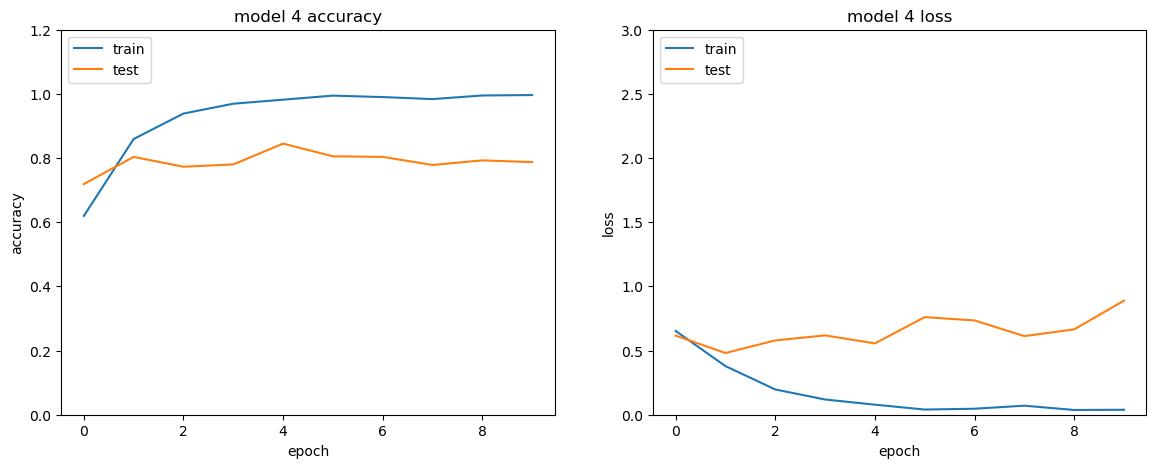

In [22]:
plot_history(history4, 'model 4')

In [40]:

# Modèle 4 : LSTM bi-directionnel et return_sequences=False
model4 = Sequential()
model4.add(Embedding(num_words, embed_size)) 

model4.add(LSTM(units=128, return_sequences=True))
model4.add(LSTM(units=64, return_sequences=True))
model4.add(LeakyReLU())

model4.add(Dropout(0.2))

model4.add(LSTM(units=32, return_sequences=True))
model4.add(LSTM(units=16, return_sequences=True))
model4.add(LeakyReLU())

model4.add(Dropout(0.2))

model4.add(LSTM(units=8, return_sequences=False))
model4.add(LeakyReLU())

model4.add(Dropout(0.2))

model4.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))

# On affiche l'architecture de notre modèle
model4.summary()

# On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, None, 128)         640000    
                                                                 
 lstm_35 (LSTM)              (None, None, 128)         131584    
                                                                 
 lstm_36 (LSTM)              (None, None, 64)          49408     
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, None, 64)          0         
                                                                 
 dropout_20 (Dropout)        (None, None, 64)          0         
                                                                 
 lstm_37 (LSTM)              (None, None, 32)          12416     
                                                                 
 lstm_38 (LSTM)              (None, None, 16)        

In [41]:
history4 = model4.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2) # on entraine


Epoch 1/10
35/35 [==============================] - 14s 259ms/step - loss: 0.6952 - accuracy: 0.5694 - val_loss: 0.6397 - val_accuracy: 0.7243
Epoch 2/10
35/35 [==============================] - 8s 230ms/step - loss: 0.5377 - accuracy: 0.8192 - val_loss: 0.5132 - val_accuracy: 0.7982
Epoch 3/10
35/35 [==============================] - 8s 242ms/step - loss: 0.3835 - accuracy: 0.9031 - val_loss: 0.4911 - val_accuracy: 0.8126
Epoch 4/10
35/35 [==============================] - 9s 263ms/step - loss: 0.2909 - accuracy: 0.9477 - val_loss: 0.4904 - val_accuracy: 0.8072
Epoch 5/10
35/35 [==============================] - 10s 295ms/step - loss: 0.2546 - accuracy: 0.9540 - val_loss: 0.4648 - val_accuracy: 0.8180
Epoch 6/10
35/35 [==============================] - 11s 301ms/step - loss: 0.2097 - accuracy: 0.9716 - val_loss: 0.5379 - val_accuracy: 0.7802
Epoch 7/10
35/35 [==============================] - 10s 295ms/step - loss: 0.1876 - accuracy: 0.9752 - val_loss: 0.5307 - val_accuracy: 0.8126
Ep

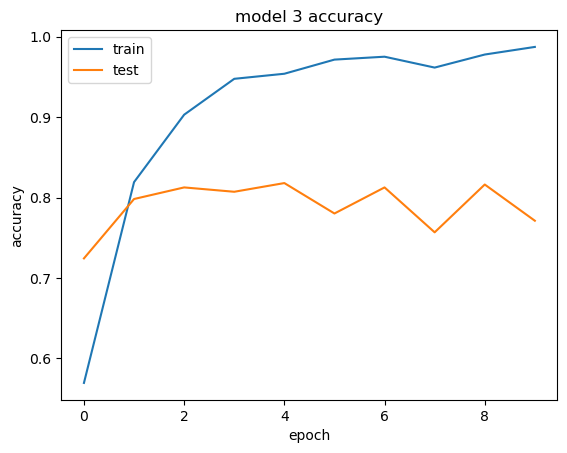

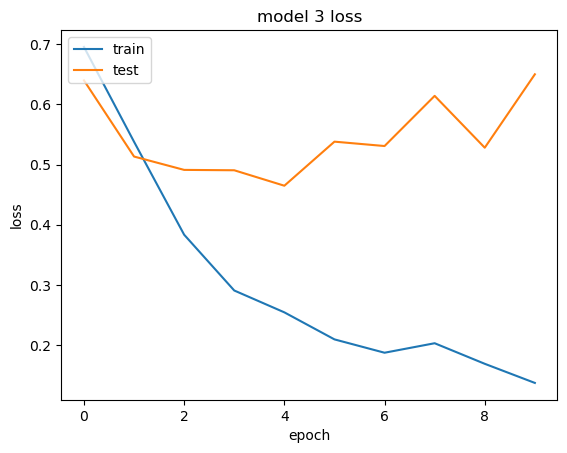

In [42]:
h = history4

# On trace la loss et l'accuracy du modèle
# On trace l'évolution de l'accuracy
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy']) 
plt.title('model 3 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# On trace l'évolution de la loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model 3 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()